In [12]:
import pandas as pd
import bamboolib
import os
import datetime
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

import seaborn as sns
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from IPython.core.display import display, HTML
import re

In [3]:
current_directory = os.getcwd()
print(current_directory)

/home/aymeric/python-scripts/anses_medialab/analyse_tweets


## Analyse des segments

In [4]:
aymeric =  "/home/aymeric/python-scripts/anses_medialab/datas/" #aymeric
jp = '~/Dropbox/Mac/Desktop/CRD Anses/all3/' # Jean Philippe
jp_index = '~/Dropbox/Mac/Desktop/CRD Anses/code/indexation_results/' # Jean Philippe index

if 'aymeric' in current_directory:
    path_base = aymeric
    index=f"{path_base}index_allall_domainsexhaustive.csv"
else:
    path_base = jp
    index=f'{jp_index}index_allall_domainsexhaustive.csv'


file_segmentation = f"{path_base}segmentation_common_freq.csv"
data_file = path_base+'fb_tw_med_data.csv.gz'#,line_terminator='\n',index=False)


all_corpus = f"{path_base}all_corpus_seg_with_sdhi_PI.csv"
cluster_qualification = f"{path_base}cluster_qualification.csv"

#twittos = f"{path_base}tweets_pesticides/500_first_twittos_on_pesticides.csv"




In [5]:
list_base = ["index", "all_corpus"]
which_base = list_base[0]

In [6]:
dfseg0 = pd.read_csv(file_segmentation, sep = "\t")
df_cluster = pd.read_csv(cluster_qualification, sep = "\t")

if which_base == "all_corpus":
    df0 = pd.read_csv(all_corpus, sep = "\t")
else:
    df_index = pd.read_csv(index, sep = "\t")

    df_index['date'] = pd.to_datetime(df_index['date'], infer_datetime_format=True)
    df_index['yearmonth']=(df_index['date'].dt.strftime('%Y-%m'))
    df_index['date'] = df_index['date'].dt.date
    
    segment = dfseg0[["yearmonth", "segm", "origin"]]
    df0 = df_index.merge(segment, how = "inner", on = ["origin", "yearmonth"])
    df0["start_segment"] = df0.groupby(['origin','segm'])["date"].transform('min')
    df0["end_segment"] = df0.groupby(['origin','segm'])["date"].transform('max')

In [7]:
dft = pd.read_csv(data_file)


/home/aymeric/anaconda3/envs/analyse_tweets/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
# Step: Rename column
dft = dft.rename(columns={'id': 'doc_id'})

dft['date'] = pd.to_datetime(dft['date'], infer_datetime_format=True)

dft['yearmonth']=(dft['date'].dt.strftime('%Y-%m'))
dft['date'] = dft['date'].dt.date
    
segment = dfseg0[["yearmonth", "segm", "origin"]]
dft0 = dft.merge(segment, how = "inner", on = ["origin", "yearmonth"])
dft0["start_segment"] = dft0.groupby(['origin','segm'])["date"].transform('min')
dft0["end_segment"] = dft0.groupby(['origin','segm'])["date"].transform('max')



In [16]:
dfseg0

     Unnamed: 0    origin yearmonth  segm  doc_id  \
0             0  facebook   2011-11   0.0       6   
1             1  facebook   2011-12   0.0      25   
2             2  facebook   2012-02   1.0       9   
3             3  facebook   2012-04   1.0       6   
4             4  facebook   2012-03   1.0       9   
..          ...       ...       ...   ...     ...   
390         390     media   2012-12   5.0      45   
391         391     media   2011-10   3.0       3   
392         392     media   2011-09   3.0      11   
393         393     media   2011-01   1.0      15   
394         394     media   2011-02   1.0      24   

                                  top50_term_chi2_True  \
0    céréalier charentais, efsa, paul françois, mon...   
1    céréalier charentais, efsa, paul françois, mon...   
2    santé des français, semences transgéniques, ag...   
3    santé des français, semences transgéniques, ag...   
4    santé des français, semences transgéniques, ag...   
..             

## Facebook

In [39]:
def filter_data(data, domain, segment):
    print(domain)
    dfseg = data[0]
    dfseg1 = dfseg.loc[(dfseg["origin"] == domain) & (dfseg["segm"] == segment)]
    
    df = data[1]
    df1 = df.loc[(df["origin"] == domain) & (df["segm"] == segment)]
    
    dft = data[2]
    dft1 = dft.loc[(dft["origin"] == domain) & (dft["segm"] == segment)]
    dft1['doc_id'] = dft1['doc_id'].astype('string')
    
    specific_terms = [x.strip() for x in dfseg1["top50_term_chi2_True"].iloc[0].split(",")]

    print(specific_terms)
    df1.loc[df1["term"].isin(specific_terms) == True, "in_top50_term"] = 1
    df1.loc[df1["term"].isin(specific_terms) == False, "in_top50_term"] = 0

    
    df2 = df1.drop_duplicates(subset = ["doc_id", "term"]).groupby(['doc_id', 'source', "date"]).agg(sum_of_top50_term =('in_top50_term', 'sum')).reset_index()
    df2['doc_id'] = df2['doc_id'].astype('string')
    df2 = df2.merge(dft1[["doc_id", "text"]], how = "inner", on = ["doc_id"])
    
    return dfseg1, df1, dft1, df2, specific_terms

In [115]:
domains = ["facebook", "twitter", "media"]
segment = 0
domain = domains[0]

list_df = [dfseg0, df0, dft0]
dfseg1, df1, dft1, df2, specific_terms = filter_data(list_df, domain = domain, segment = segment)

facebook
['céréalier charentais', 'efsa', 'paul françois', 'monsanto', 'procès', 'lasso', 'résidus de pesticides', 'victimes de pesticides', 'agriculture biologique', 'monde selon monsanto', 'générations futures', 'tribunal', 'aliments', 'futures', 'résidus', 'victimes', 'roundup', 'inra', 'firme', 'épandages', 'associations', 'pesticides', 'sucre', 'martinique', 'effet', 'syngenta', 'agriculteur', 'docteur', 'planète', 'céréaliers', 'femmes', 'épandages de pesticides', 'apiculture', 'études', 'recherche', 'agrochimie', 'cour', 'sécurité des aliments', 'autorité européenne', 'dérogation', 'alternatives aux pesticides', 'parlement', 'arguments', 'malformations', 'pollution', 'alternatives', 'extinction', 'combat', 'pac', 'abeilles']


In [116]:
df2

     doc_id                                             source        date  \
0    413876         Consommons de façon responsable et éthique  2011-12-30   
1    413877          Le mystère de la disparition des abeilles  2011-12-30   
2    413878                                         Doctissimo  2011-12-28   
3    413879                                 Biocoop Les Halles  2011-12-28   
4    413880  Libres de pensées. Contre la banalisation de l...  2011-12-27   
..      ...                                                ...         ...   
139  414020                                        eco-SAPIENS  2011-11-22   
140  414022                        La Lettre à Jal & Compagnie  2011-11-18   
141  414023                        Good Smile Company (France)  2011-11-18   
142  414024                                 Bio Consom'acteurs  2011-11-16   
143  414025                 Les eurodéputé·e·s Europe écologie  2011-11-16   

     sum_of_top50_term                                         

In [117]:
moyenne = np.mean(df2["sum_of_top50_term"]) 
df3 = df2.loc[df2["sum_of_top50_term"] >= 1 ]
df3 = df3.sort_values(by=['date'], ascending=[True])

#df3 = df3.drop_duplicates(subset = "text")

## Matrice de similarité

In [118]:
df11 = df1.groupby(['term', 'doc_id']).agg(count_doc = ("doc_id", "count")).reset_index()
df11=df11.merge(df1[['term','in_top50_term']].drop_duplicates(), on='term', how = 'left')
df11=df11.loc[df11["in_top50_term"] ==  1]

In [119]:
import math


dico_freq={}
for l in df11.groupby('term'):
    term=l[0]
    #print (term)
    dico_freq[term]={}
    for d in l[1].groupby('doc_id'):
        #print (d[0],d[1]['count_doc'].values[0])
        dico_freq[term][d[0]]=d[1]['count_doc'].values[0]

for t in dico_freq:
    N=sum(dico_freq[t].values())
    for d in dico_freq[t]:
        dico_freq[t][d]=dico_freq[t][d]/N
    
                
squared={}
spec_words=list(dico_freq.keys())
for w1 in spec_words:
    s=0
    for d1 in dico_freq[w1]:
        #if d1 in spec_words[w2]:
        s += dico_freq[w1][d1] * dico_freq[w1].get(d1,0)
    squared[w1]=s

similarity=[]
spec_words=list(dico_freq.keys())
for w1 in spec_words:
    sim=[]
    for w2 in spec_words:
        s=0
        for d1 in dico_freq[w1]:
            #if d1 in spec_words[w2]:
            s += dico_freq[w1][d1] * dico_freq[w2].get(d1,0)
        sim.append(s/math.sqrt(squared[w1]*squared[w2]))
    similarity.append(sim)

#similarity

In [120]:
list_name = [x for x in df11.term.unique()]
print(list_name)

['abeilles', 'agriculteur', 'agriculture biologique', 'agrochimie', 'aliments', 'alternatives', 'alternatives aux pesticides', 'apiculture', 'arguments', 'associations', 'autorité européenne', 'combat', 'cour', 'céréalier charentais', 'céréaliers', 'docteur', 'dérogation', 'effet', 'efsa', 'extinction', 'femmes', 'firme', 'futures', 'générations futures', 'inra', 'lasso', 'malformations', 'martinique', 'monde selon monsanto', 'monsanto', 'pac', 'parlement', 'paul françois', 'pesticides', 'planète', 'pollution', 'procès', 'recherche', 'roundup', 'résidus', 'résidus de pesticides', 'sucre', 'syngenta', 'sécurité des aliments', 'tribunal', 'victimes', 'victimes de pesticides', 'épandages', 'épandages de pesticides', 'études']


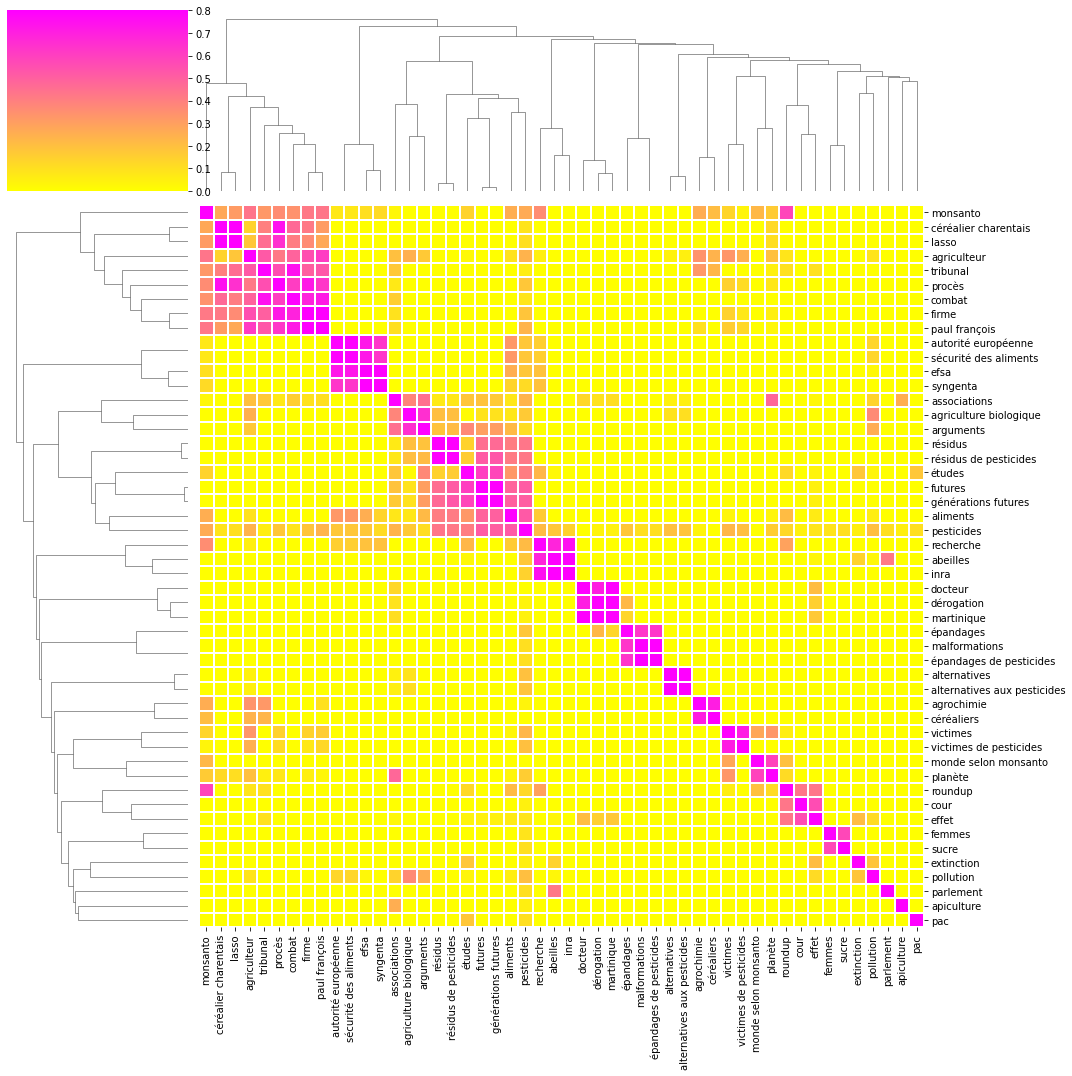

In [121]:
from matplotlib import pyplot as plt


cmap_reversed = plt.cm.get_cmap('spring_r')
#sns.clustermap(rho_terms)
ax=sns.clustermap(similarity,figsize=(15,15), cmap = cmap_reversed, linewidths=2, linecolor='white', vmax = 0.8)#,labels=range(14))
new_labels=[]
labels_list= list_name
for l in ax.ax_heatmap.axes.get_xticklabels():
    l.set_text(labels_list[int(l.get_text())])
    new_labels.append(l)
ax.ax_heatmap.axes.set_yticklabels(new_labels,rotation=0)
ax.ax_heatmap.axes.set_xticklabels(new_labels,rotation = 90)

#ax.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.tight_layout()

plt.savefig(f"clustermap/cm_{domain}_{segment}.png")

## Détermination du nombre de clusters avec kneed Locator

In [122]:
fig = plt.figure(1, figsize=(15, 5))
row_linkage = linkage(sp.distance.pdist(similarity), method='complete')# for x in (t.values, rho_terms.values.T))
nbclust_max=20
dfcost=pd.DataFrame()
for nbclust in  range(1,nbclust_max):
    cluster_idx = scipy.cluster.hierarchy.fcluster(row_linkage,nbclust,criterion='maxclust')
    cluster = [y for y in cluster_idx]    
    new_df = pd.DataFrame(data = {"term": list_name, "cluster": cluster})
    new_df['nbseg']=nbclust
    new_df_count = new_df.groupby(['cluster']).agg(term_size=('term', 'size')).reset_index()
    new_df_count = new_df_count.loc[new_df_count['term_size'] == 1]
    if len(new_df_count)>0:
        break
        
    dfcost=dfcost.append(new_df)
    
#Liste des distances entre chaque paire de termes
df_sim['v1']=df_sim.index
df_sim_melt = df_sim.melt(id_vars=['v1'])
df_sim_melt.columns=['v1', 'v2', 'sim']
df_sim_melt['dist']=1-df_sim_melt['sim']
df_sim_melt

                       v1            v2       sim      dist
0            @genefutures  @genefutures  1.000000  0.000000
1                abeilles  @genefutures  0.001486  0.998514
2     autorité européenne  @genefutures  0.000000  1.000000
3                 cancers  @genefutures  0.016128  0.983872
4             cancérogène  @genefutures  0.000000  1.000000
...                   ...           ...       ...       ...
2495             troubles        études  0.147782  0.852218
2496              viandes        études  0.064711  0.935289
2497            vignerons        études  0.009042  0.990958
2498               vignes        études  0.023740  0.976260
2499               études        études  1.000000  0.000000

[2500 rows x 4 columns]

<Figure size 1080x360 with 0 Axes>

## Distance moyenne entre éléments de chaque cluster (avec nombre de cluster compris entre 1 et 20)

In [123]:
df_dist_clust = pd.merge(df_sim_melt, dfcost, how='inner', left_on=['v1'], right_on=['term'])
df_dist_clust = pd.merge(df_dist_clust, dfcost, how='inner', left_on=['v2'], right_on=['term'])
df_dist_clust = df_dist_clust.loc[df_dist_clust['nbseg_x'] == df_dist_clust['nbseg_y']]
df_dist_clust = df_dist_clust.loc[df_dist_clust['cluster_x'] == df_dist_clust['cluster_y']]
#df_dist_clust['distsq']=df_dist_clust['dist']*df_dist_clust['dist']
df_dist_clust_inertia = df_dist_clust.groupby(['nbseg_x', 'cluster_x' ,'v1']).agg(dist_mean=('dist', 'mean')).reset_index()
df_dist_clust_inertia['distsq']=df_dist_clust_inertia['dist_mean'].pow(2)



## Somme des distances moyennes au carré intra-cluster

In [124]:
df_dist_clust_inertia = df_dist_clust_inertia.groupby(['nbseg_x', 'cluster_x']).agg(dist_mean_sum=('distsq', 'sum')).reset_index()
df_dist_clust_inertia

    nbseg_x  cluster_x  dist_mean_sum
0         1          1       8.989135
1         2          1       0.531301
2         2          2       6.303283
3         3          1       0.531301
4         3          2       0.258072
..      ...        ...            ...
85       17          5       0.258072
86       17          6       1.048156
87       17          7       0.413052
88       17          9       0.000000
89       17         14       0.000000

[90 rows x 3 columns]

## Somme des distances moyennes au carré inter-cluster

In [125]:
df_dist_clust_inertia = df_dist_clust_inertia.groupby(['nbseg_x']).agg(dist_mean_sum=('dist_mean_sum', 'sum')).reset_index()
df_dist_clust_inertia

    nbseg_x  dist_mean_sum
0         1       8.989135
1         2       6.834584
2         3       5.612533
3         4       3.863615
4         5       2.734329
5         6       2.734329
6         7       2.250581
7         8       2.250581
8         9       2.250581
9        10       2.250581
10       11       2.250581
11       12       2.250581
12       13       2.250581
13       14       2.004629
14       15       2.004629
15       16       2.004629
16       17       2.004629

## Distribution de dist_mean_sum

In [126]:
import plotly.express as px
fig = px.scatter(df_dist_clust_inertia, x='nbseg_x', y='dist_mean_sum', width=800, height=600)
fig

In [127]:
from kneed import KneeLocator
x=df_dist_clust_inertia['nbseg_x'].values
y=df_dist_clust_inertia['dist_mean_sum'].values
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
nb_segm_optimal=kn.knee
print(nb_segm_optimal)

dfcost = dfcost.loc[dfcost['nbseg'] == nb_segm_optimal]
dfcost = dfcost.sort_values(by=['cluster'], ascending=[True])

dfcost = dfcost.loc[dfcost['nbseg'] == nb_segm_optimal]
dfcost = dfcost.sort_values(by=['cluster'], ascending=[True])
dfcost

7


                           term  cluster  nbseg
11                       combat        1      7
1                   agriculteur        1      7
21                        firme        1      7
44                     tribunal        1      7
25                        lasso        1      7
29                     monsanto        1      7
32                paul françois        1      7
36                       procès        1      7
13         céréalier charentais        1      7
23          générations futures        2      7
22                      futures        2      7
2        agriculture biologique        2      7
4                      aliments        2      7
40        résidus de pesticides        2      7
49                       études        2      7
9                  associations        2      7
39                      résidus        2      7
33                   pesticides        2      7
8                     arguments        2      7
43        sécurité des aliments        3

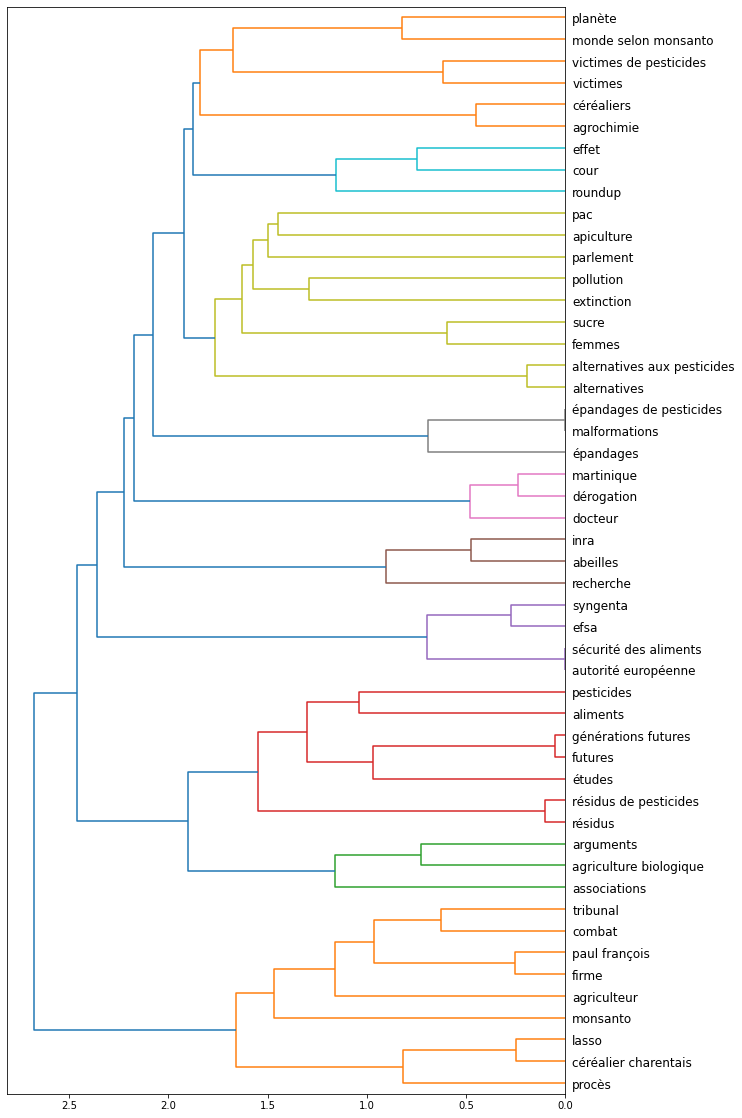

In [129]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

fig = plt.figure(1, figsize=(10, 20))
#th = 1.63
row_linkage = linkage(sp.distance.pdist(similarity), method='complete')# for x in (t.values, rho_terms.values.T))
dn = dendrogram(row_linkage, leaf_font_size= 12, labels=list_name, orientation = "left")
#plt.axvline(x=th, c='grey', lw=1, linestyle='dashed')

cluster_idx = scipy.cluster.hierarchy.fcluster(row_linkage,t= th,criterion="distance")
plt.savefig(f"clustermap/dendogram_{domain}_{segment}.png")

In [92]:

cluster = [y for y in cluster_idx]
    
new_df = pd.DataFrame(data = {"term": list_name, "cluster": cluster})
new_df.sort_values("cluster", ascending = True)

dic_cluster = {1 : "Alternatives aux pesticides", 
               2 : "Contre le monde de Monsanto",  
               3 : "Médecins", 
               4 :"Résidus chimiques",
               5 : "Expertise et risque sanitaire",
               6 : "Les systèmes agricoles en question",
               7 : "Abeilles et néonicotinoïdes",
               8 : "OGM et herbicides",
               9 : "Générations futures",
               10 : "Les résidus de pesticides dans l'alimentation"
              }

print(new_df.sort_values("cluster", ascending = True))
#print(len(dic_cluster), len(cluster))


                          term  cluster
2          autorité européenne        1
13                        efsa        1
40       sécurité des aliments        1
1                     abeilles        2
34                      ruches        2
7          colonies d'abeilles        2
41           taux de mortalité        2
22                   mortalité        2
47                   vignerons        3
48                      vignes        3
9                  corrélation        4
19               malformations        4
42           terre de diatomée        5
43                      traces        5
15         grande distribution        5
16                  greenpeace        5
23                   moustique        5
20                      milieu        5
0                 @genefutures        5
29                  pesticides        6
37               scientifiques        6
36                       santé        6
38                  substances        6
45                    troubles        6


In [ ]:
nombre_texts = len(df3["text"])
start_segment = df1["start_segment"].iloc[1]#.strftime("%Y-%m-%d")
end_segment = df1["end_segment"].iloc[1]#.strftime("%Y-%m-%d")

for i, text in enumerate(df3["text"]):
    doc_id = df3["doc_id"].iloc[i]
    list_term = [x for x in df1["term"].loc[(df1["doc_id"] == doc_id)].unique()]
    term_to_search = ['victimes']
    nb_term_to_search = [x for x in term_to_search if x in list_term]
    
    if len(nb_term_to_search) >= 0:
        #Thematique = "Tous contre Monsanto"
        #df1.loc[(df1["doc_id"].str.contains(doc_id) == True), "Subject"] = Thematique
        list_top50_term = [x for x in df1["term"].loc[(df1["doc_id"] == doc_id) & (df1["in_top50_term"] == 1)].unique()]
        list_top50_term_absent = set(specific_terms) - set(list_top50_term)
        date = df3["date"].iloc[i]#.strftime("%Y-%m-%d")
        auteur = df3["source"].iloc[i]
        display(HTML(f"<h2 style='text-align:center;'> Texte {doc_id} ({i+1} sur {nombre_texts})</h2>"))
        display(HTML(f"<strong>Segment :</strong> {segment} ({start_segment} ; {end_segment})"))
        display(HTML(f"<strong>Date :</strong> {date}"))
        display(HTML(f"<strong>Auteur :</strong> {auteur} \n"))
        print(f"Termes indexés : {list_term} \n")
        print(f"Termes spécifiques présents : {list_top50_term} \n")
        print(f"Termes spécifiques absents : {list_top50_term_absent} \n")
        #display(HTML(f"<strong>Thématique :</strong> {Thematique} \n"))
        try:
            text1 = text
            for j, term in enumerate(list_term):
                if term not in list_top20_term:
                    text1 = re.sub(term, f'<mark style="background-color:yellow">{term}</mark>', text1, flags=re.I)  
                else:
                    text1 = re.sub(term, f'<mark style="background-color:pink">{term}</mark>', text1, flags=re.I)  
            display(HTML(f'{text1}'))
        except:
            print(f"{text} \n")
    else:
        pass
   

In [79]:
new_df["cluster_name"] = new_df['cluster'].map(dic_cluster)  
new_df["origin"] = domain
new_df["segm"] = segment
new_df.sort_values("cluster", ascending = True)


,term,cluster,cluster_name,origin,segm
3,alternatives,1,Alternatives aux pesticides,facebook,3
4,alternatives aux pesticides,1,Alternatives aux pesticides,facebook,3
24,nature,2,Contre le monde de Monsanto,facebook,3
22,monsanto,2,Contre le monde de Monsanto,facebook,3
25,ogm,2,Contre le monde de Monsanto,facebook,3
6,citoyens,2,Contre le monde de Monsanto,facebook,3
7,collectifs,2,Contre le monde de Monsanto,facebook,3
21,monde,2,Contre le monde de Monsanto,facebook,3
39,résistances,2,Contre le monde de Monsanto,facebook,3
23,médecin,3,Médecins,facebook,3


In [83]:
df_cluster = pd.read_csv(cluster_qualification, sep = "\t").drop(columns = ["Unnamed: 0"])

In [84]:
df_cluster

,term,cluster,cluster_name,origin,segm
0,pesticides,2.0,Rapport de Génération future,facebook,0.0
1,cancers,11.0,Les agriculteurs victimes des phyto,facebook,0.0
2,parasite,10.0,Le déclin des abeilles,facebook,0.0
3,effet,10.0,Le déclin des abeilles,facebook,0.0
4,abeilles,10.0,Le déclin des abeilles,facebook,0.0
...,...,...,...,...,...
147,traitements,5.0,Traitements phytosanitaires,facebook,2.0
148,travail,7.0,Les risques sanitaires,facebook,2.0
149,épandages,2.0,Les épandages aériens en Guadeloupe,facebook,2.0
150,épandages de pesticides,3.0,Les épandages aériens,facebook,2.0


In [86]:
new_df2 = pd.concat([df_cluster, new_df])
new_df2

,term,cluster,cluster_name,origin,segm
0,pesticides,2.0,Rapport de Génération future,facebook,0.0
1,cancers,11.0,Les agriculteurs victimes des phyto,facebook,0.0
2,parasite,10.0,Le déclin des abeilles,facebook,0.0
3,effet,10.0,Le déclin des abeilles,facebook,0.0
4,abeilles,10.0,Le déclin des abeilles,facebook,0.0
...,...,...,...,...,...
44,syngenta,7.0,Abeilles et néonicotinoïdes,facebook,3.0
45,systèmes,6.0,Les systèmes agricoles en question,facebook,3.0
46,traitements,6.0,Les systèmes agricoles en question,facebook,3.0
47,travail,6.0,Les systèmes agricoles en question,facebook,3.0


In [87]:
new_df2.to_csv(f'{path_base}cluster_qualification.csv', sep = "\t") #cluster qualifié par origin et segment

## Facebook

### 1ère période : 16 novembre 2011 -- 31 janvier 2012:1ère période (Segment 0)

<img src="clustermap/cm_facebook_0.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

##### 
La première période sur facebook semble être caractérisée par trois thématiques:

- La première concerne le procès opposant Paul François (céréalier charantais) à Monsanto. Paul François s'est retrouvé dans le coma après avoir nettoyé une cuve contenant du Lasso (produit commercialisé par Monsanto). Le débat a débuté le 12 décembre 2011.

> pesticides : un agriculteur en procès contre monsanto Ce lundi 12 décembre 2011, paul françois, agriculteur victime des pesticides, sera en procès contre monsanto, en première instance, au TGI de Lyon, dans l'espoir de faire reconnaître la faute de la firme et d'engager la responsabilité de cette dernière. bioaddict.fr Nous en appelons à toutes celles et ceux qui le souhaitent à se rendre au TGI de Lyon le 12 décembre à 13h30 pour témoigner de leur soutien à paul françois et, ainsi, à toutes les victimes des pesticides. [Auteur : BIO ADDICT]

- Un deuxième ensemble de textes évoque le problème du déclin des pollinisateurs et, plus spécifiquemet, des abeilles. Les "termes spécifiques" du segment 0 que l'on retrouve dans ces textes sont par exemple : *'effet', 'pesticides', 'miel', 'parasite'*. **"Parasites"** et **"pesticides"** font référence à deux des causes supposées de disparition des abeilles (les pesticides à travers les néonicotinoïdes et les parasites avec le Varoa). Une disparition qui se manifesterait notamment par une baisse de production du **miel**.


> Fin des abeilles = fin du monde ? Oui bon, c’est peut-être un peu exagéré. Quoique…sans les abeilles, l’équilibre écologique serait gravement menacé. En effet, les abeilles ont un rôle essentiel pour la survie des végétaux depuis 50 millions d’années [...] On a découvert que les abeilles sont toxico-sensibles et donc plus vulnérables que la plupart des autres insectes aux <mark>pesticides</mark>. [...] En France, le Gaucho de Bayer et le Régent de BASF, deux insecticides accusés de ravager les abeilles, ont été interdits en 2006 mais malgré tout l’hécatombe se poursuit dans les ruches. On ne sait pas bien pourquoi et cela est très préoccupant. <mark>Certains apiculteurs soupçonnent que les pesticides</mark> toujours utilisés par l’agriculture sont à l’origine de ce qu’on appelle désormais le « syndrome d’effondrement des colonies », maladie dont on ne sait pas encore grand-chose. [...] Récemment, <mark>d’autres explications</mark> ont été données quant à la disparition des abeilles : 
> - <mark>Le frelon asiatique</mark> est montré du doigt. Cet insecte venu de l’étranger est un prédateur féroce pour les abeilles puisqu’il se nourrit de leurs larves. 
> - <mark>Une mouche parasite</mark> est également mise en cause depuis peu. Une étude américaine publiée en janvier 2012 a en effet mis en lumière le rôle néfaste de la mouche Apocephalus borealis. [Auteur: Let's save our Earth - Sauvons notre planète]

- Un troisième ensemble de textes porte sur le rapport publié par Génération futures sur les  résidus de pesticides dans l'alimentation

> Choisir de manger bio, c'est protéger sa santé L'association générations futures a effectué des tests comparant un menu conventionnel et un menu bio : le résultat est sans appel, le menu bio ne contenant quasiment aucun résidus de pesticides. "Il y a 223 fois moins de résidus de pesticides en moyenne dans les aliments bio analysés que dans les a... bioaddict.fr Mangez bio, c'est bon pour la santé ! Et ça, c'est vachement bien ! [Auteur : Les 2 vaches, industrie agroalimentaire]

- On trouve ensuite les textes qui prennent pour cible "Monsanto et son monde" ainsi que les effets sanitaires des produits commercialisés par la firme. Il s'agit probablement d'un ensemble de réactions à la suite de la sortie du film éponyme *Le monde selon Monsanto*.

> *Le monde selon Monsanto* : Ce film retrace l'histoire de monsanto, une multinationale américaine, aujourd'hui leader mondial des ogm, et considérée comme l'un des plus grands pollueurs de l'ère industrielle (PCB, agent orange, hormones de croissance, roundup...). Après une enquête de trois ans, en Amérique du nord et du sud, en europe et en Asie, il reconstitue la genèse d'un empire industriel, qui, à grand renfort de rapports mensongers, de collusion avec l'administration nord-américaine, de pressions et tentatives de corruption, est devenu l'un des premiers semenciers de la planète.

Il est intéressant de noter que Monsanto (et d'autres firmes comme Syngenta ou Bayer) semble être le lien entre différents "cluster": l'affaire Paul François, les débats liés au Roundup.

- Enfin, de nombreux posts évoquent les "pesticides" de façon générale sans faire de lien à une affaire en particulier.

## Test (annexe)

In [ ]:
text = df2['text'].loc[(df2["doc_id"] == "413916")]
for x in text :
    print(x)

In [ ]:
text = """Santé Canada reçoit l'ordre de réexaminer les effets environnementaux du Roundup | equiterre.org 
- P La Cour fédérale du Canada a ordonné à Santé Canada de réévaluer sa décision de ne pas examiner les effets 
d'un herbicide, commercialisé sous le nom de Roundup. Ce pesticide est un des plus populaires sur le marché et 
il accompagne une proportion importante des plantes modifiées génétiquement utilis... equiterre.org 
Santé Canada reçoit l'ordre de la Cour fédérale de réexaminer les effets environnementaux du RoundUp!"""

In [ ]:
list_term = ["pesticides", "roundup"]

In [ ]:
import re
for j, term in enumerate(list_term):
    if term[-1]== "s":
        singular_term = term[0:-1]
    else:
        singular_term = term
    #text = text.replace(term[0:len(term)-1], f'<mark style="background-color:yellow">{term}</mark>')
    text = re.sub(term, f'<mark style="background-color:yellow">{term}</mark>', text, flags=re.I)          #

display(HTML(f'{text}'))